In [7]:
import numpy as np
import pylab as plt
plt.rcParams['figure.figsize'] = [8, 8]
plt.rcParams['font.size'] = 12
import emcee
import scipy.stats
import corner
import dynesty
from dynesty import utils as dyfunc
from dynesty import plotting as dyplot

In [8]:
data= np.load('transient.npy')

First, always start with a quick look at the data

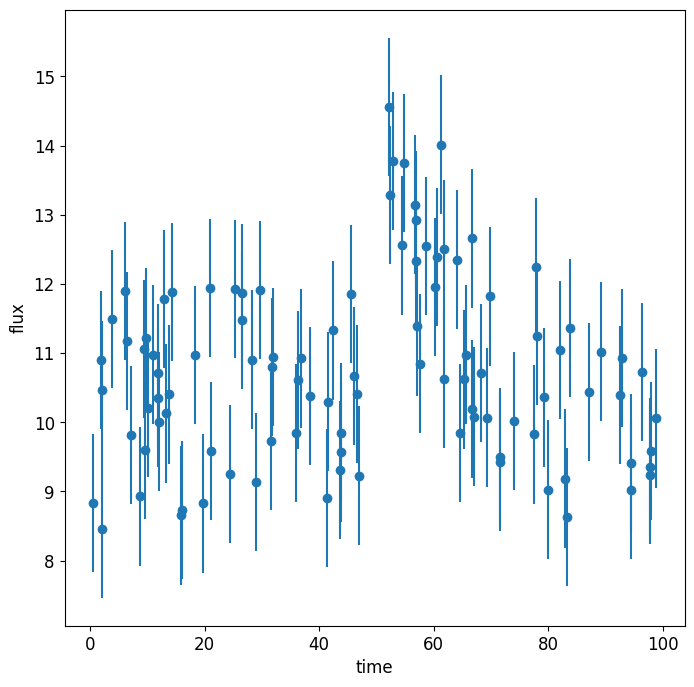

In [9]:
t,y,yerr=data.T
plt.errorbar(t,y,yerr=yerr,fmt='o')
plt.xlabel("time")
plt.ylabel("flux");

These are the old burst model and the new gaussian profile model:

In [10]:
def burst(theta,t):
    A,b,t0,alpha=theta 
    return np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0)))


def gprofile(theta,t):
    A,b,t0,sigmaW=theta     
    return b+A*np.exp(-(((t-t0)/sigmaW)**2 ) / 2)


t0min,t0max = 0,100
Amin,Amax=0,50
bmin,bmax=0,50
alphamin,alphamax=np.exp(-5),np.exp(5)
sigmaWmin,sigmaWmax=np.exp(-2),np.exp(2)



First, let's reproduce our previous results using dinesty

In [11]:
# Define the dimensionality of our problem.
ndim = 4

def loglike(theta, data, model):
    x, y, sigma_y = data.T
    if model =='burst':
        y_fit = burst(theta, x)
    elif model == 'gprofile':
        y_fit = gprofile(theta, x)

    # Note I'm not tracking the normalization here! 
    # Ok because here I only care about the ratio between two evidences, not the evidence itself
    return -0.5 * np.sum((y-y_fit)**2 / sigma_y**2 ) 


def ptform(u,model):
    """Transforms the uniform random variables `u ~ Unif[0., 1.)`
    to the parameters of interest."""

    x = np.array(u)  # copy u

    x[0] = scipy.stats.uniform(loc=Amin,scale=Amax-Amin).ppf(u[0])
    x[1] = scipy.stats.uniform(loc=bmin,scale=bmax-bmin).ppf(u[1])
    x[2] = scipy.stats.uniform(loc=t0min,scale=t0max-t0min).ppf(u[2])
   
    if model =='burst':
        x[3] = scipy.stats.loguniform.ppf(u[3],alphamin,alphamax)
    elif model =='gprofile':
        x[3] = scipy.stats.loguniform.ppf(u[3],sigmaWmin,sigmaWmax)
        #x[3] = scipy.stats.uniform(loc=sigmaWmin,scale=sigmaWmax-sigmaWmin).ppf(u[3])

    return x

In [12]:
# "Static" nested sampling.
sampler = dynesty.NestedSampler(loglike, ptform, ndim,logl_args=[data,'burst'],ptform_args=['burst'],nlive=300)
sampler.run_nested()
sresults = sampler.results

/var/folders/zv/8t9z941x3q1gmp080mdw8k_h0000gn/T/ipykernel_98481/2122527065.py:3: RuntimeWarning: overflow encountered in exp
  return np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0)))
/var/folders/zv/8t9z941x3q1gmp080mdw8k_h0000gn/T/ipykernel_98481/2122527065.py:3: RuntimeWarning: overflow encountered in multiply
  return np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0)))
1096it [00:08, 55.45it/s, bound: 0 | nc: 62 | ncall: 10771 | eff(%): 10.175 | loglstar:   -inf < -181.252 <    inf | logz: -189.903 +/-  0.163 | dlogz: 103.204 >  0.309]   /var/folders/zv/8t9z941x3q1gmp080mdw8k_h0000gn/T/ipykernel_98481/2122527065.py:3: RuntimeWarning: overflow encountered in exp
  return np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0)))
1113it [00:09, 46.63it/s, bound: 1 | nc: 6 | ncall: 11096 | eff(%): 10.031 | loglstar:   -inf < -173.354 <    inf | logz: -181.566 +/-  0.157 | dlogz: 107.880 >  0.309] /var/folders/zv/8t9z941x3q1gmp080mdw8k_h0000gn/T/ipykernel_98481/2122527065.py:3: RuntimeWarning: overflow encountered i

1939it [00:14, 99.86it/s, bound: 13 | nc: 3 | ncall: 16731 | eff(%): 11.589 | loglstar:   -inf < -87.825 <    inf | logz: -94.946 +/-  0.145 | dlogz: 38.860 >  0.309]  /var/folders/zv/8t9z941x3q1gmp080mdw8k_h0000gn/T/ipykernel_98481/2122527065.py:3: RuntimeWarning: overflow encountered in exp
  return np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0)))
/var/folders/zv/8t9z941x3q1gmp080mdw8k_h0000gn/T/ipykernel_98481/2122527065.py:3: RuntimeWarning: overflow encountered in multiply
  return np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0)))
1973it [00:15, 81.61it/s, bound: 14 | nc: 5 | ncall: 17276 | eff(%): 11.420 | loglstar:   -inf < -87.670 <    inf | logz: -94.744 +/-  0.145 | dlogz: 38.543 >  0.309] /var/folders/zv/8t9z941x3q1gmp080mdw8k_h0000gn/T/ipykernel_98481/2122527065.py:3: RuntimeWarning: overflow encountered in exp
  return np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0)))
/var/folders/zv/8t9z941x3q1gmp080mdw8k_h0000gn/T/ipykernel_98481/2122527065.py:3: RuntimeWarning: overflow encountered in mult

2144it [00:21, 35.53it/s, bound: 28 | nc: 56 | ncall: 23533 | eff(%):  9.111 | loglstar:   -inf < -87.216 <    inf | logz: -94.087 +/-  0.143 | dlogz: 37.314 >  0.309] /var/folders/zv/8t9z941x3q1gmp080mdw8k_h0000gn/T/ipykernel_98481/2122527065.py:3: RuntimeWarning: overflow encountered in exp
  return np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0)))
/var/folders/zv/8t9z941x3q1gmp080mdw8k_h0000gn/T/ipykernel_98481/2122527065.py:3: RuntimeWarning: overflow encountered in multiply
  return np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0)))
2148it [00:21, 31.08it/s, bound: 29 | nc: 57 | ncall: 23689 | eff(%):  9.067 | loglstar:   -inf < -87.214 <    inf | logz: -94.077 +/-  0.143 | dlogz: 37.291 >  0.309]/var/folders/zv/8t9z941x3q1gmp080mdw8k_h0000gn/T/ipykernel_98481/2122527065.py:3: RuntimeWarning: overflow encountered in exp
  return np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0)))
/var/folders/zv/8t9z941x3q1gmp080mdw8k_h0000gn/T/ipykernel_98481/2122527065.py:3: RuntimeWarning: overflow encountered in mult

2196it [00:27, 10.60it/s, bound: 43 | nc: 79 | ncall: 30286 | eff(%):  7.251 | loglstar:   -inf < -87.174 <    inf | logz: -93.970 +/-  0.142 | dlogz: 37.023 >  0.309] /var/folders/zv/8t9z941x3q1gmp080mdw8k_h0000gn/T/ipykernel_98481/2122527065.py:3: RuntimeWarning: overflow encountered in exp
  return np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0)))
2198it [00:27, 10.86it/s, bound: 44 | nc: 42 | ncall: 30454 | eff(%):  7.217 | loglstar:   -inf < -87.173 <    inf | logz: -93.966 +/-  0.142 | dlogz: 37.013 >  0.309]/var/folders/zv/8t9z941x3q1gmp080mdw8k_h0000gn/T/ipykernel_98481/2122527065.py:3: RuntimeWarning: overflow encountered in multiply
  return np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0)))
2202it [00:27, 13.05it/s, bound: 44 | nc: 67 | ncall: 30746 | eff(%):  7.162 | loglstar:   -inf < -87.170 <    inf | logz: -93.958 +/-  0.142 | dlogz: 36.991 >  0.309]/var/folders/zv/8t9z941x3q1gmp080mdw8k_h0000gn/T/ipykernel_98481/2122527065.py:3: RuntimeWarning: overflow encountered in exp
  return np

/var/folders/zv/8t9z941x3q1gmp080mdw8k_h0000gn/T/ipykernel_98481/2122527065.py:3: RuntimeWarning: overflow encountered in exp
  return np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0)))
/var/folders/zv/8t9z941x3q1gmp080mdw8k_h0000gn/T/ipykernel_98481/2122527065.py:3: RuntimeWarning: overflow encountered in multiply
  return np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0)))
2263it [00:33,  4.33it/s, bound: 59 | nc: 754 | ncall: 37324 | eff(%):  6.063 | loglstar:   -inf < -87.124 <    inf | logz: -93.854 +/-  0.142 | dlogz: 36.684 >  0.309]/var/folders/zv/8t9z941x3q1gmp080mdw8k_h0000gn/T/ipykernel_98481/2122527065.py:3: RuntimeWarning: overflow encountered in exp
  return np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0)))
/var/folders/zv/8t9z941x3q1gmp080mdw8k_h0000gn/T/ipykernel_98481/2122527065.py:3: RuntimeWarning: overflow encountered in multiply
  return np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0)))
2265it [00:34,  4.03it/s, bound: 60 | nc: 599 | ncall: 38003 | eff(%):  5.960 | loglstar:   -inf < -87.123 <  

2295it [00:40,  9.96it/s, bound: 75 | nc: 161 | ncall: 44400 | eff(%):  5.169 | loglstar:   -inf < -87.113 <    inf | logz: -93.809 +/-  0.142 | dlogz: 36.533 >  0.309]/var/folders/zv/8t9z941x3q1gmp080mdw8k_h0000gn/T/ipykernel_98481/2122527065.py:3: RuntimeWarning: overflow encountered in exp
  return np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0)))
/var/folders/zv/8t9z941x3q1gmp080mdw8k_h0000gn/T/ipykernel_98481/2122527065.py:3: RuntimeWarning: overflow encountered in multiply
  return np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0)))
2299it [00:40,  7.97it/s, bound: 76 | nc: 127 | ncall: 45193 | eff(%):  5.087 | loglstar:   -inf < -87.111 <    inf | logz: -93.804 +/-  0.142 | dlogz: 36.514 >  0.309]/var/folders/zv/8t9z941x3q1gmp080mdw8k_h0000gn/T/ipykernel_98481/2122527065.py:3: RuntimeWarning: overflow encountered in exp
  return np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0)))
2302it [00:40, 10.22it/s, bound: 77 | nc: 129 | ncall: 45331 | eff(%):  5.078 | loglstar:   -inf < -87.109 <    inf | logz: -

2361it [00:46, 10.90it/s, bound: 90 | nc: 16 | ncall: 51421 | eff(%):  4.592 | loglstar:   -inf < -87.093 <    inf | logz: -93.734 +/-  0.142 | dlogz: 36.238 >  0.309] /var/folders/zv/8t9z941x3q1gmp080mdw8k_h0000gn/T/ipykernel_98481/2122527065.py:3: RuntimeWarning: overflow encountered in exp
  return np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0)))
/var/folders/zv/8t9z941x3q1gmp080mdw8k_h0000gn/T/ipykernel_98481/2122527065.py:3: RuntimeWarning: overflow encountered in multiply
  return np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0)))
2365it [00:46,  9.47it/s, bound: 91 | nc: 199 | ncall: 51982 | eff(%):  4.550 | loglstar:   -inf < -87.092 <    inf | logz: -93.730 +/-  0.142 | dlogz: 36.220 >  0.309]/var/folders/zv/8t9z941x3q1gmp080mdw8k_h0000gn/T/ipykernel_98481/2122527065.py:3: RuntimeWarning: overflow encountered in exp
  return np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0)))
/var/folders/zv/8t9z941x3q1gmp080mdw8k_h0000gn/T/ipykernel_98481/2122527065.py:3: RuntimeWarning: overflow encountered in mul

/var/folders/zv/8t9z941x3q1gmp080mdw8k_h0000gn/T/ipykernel_98481/2122527065.py:3: RuntimeWarning: overflow encountered in multiply
  return np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0)))
2396it [00:52,  9.28it/s, bound: 106 | nc: 114 | ncall: 58673 | eff(%):  4.084 | loglstar:   -inf < -87.090 <    inf | logz: -93.702 +/-  0.141 | dlogz: 36.089 >  0.309]/var/folders/zv/8t9z941x3q1gmp080mdw8k_h0000gn/T/ipykernel_98481/2122527065.py:3: RuntimeWarning: overflow encountered in exp
  return np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0)))
/var/folders/zv/8t9z941x3q1gmp080mdw8k_h0000gn/T/ipykernel_98481/2122527065.py:3: RuntimeWarning: overflow encountered in multiply
  return np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0)))
2402it [00:53, 12.19it/s, bound: 107 | nc: 76 | ncall: 59075 | eff(%):  4.066 | loglstar:   -inf < -87.090 <    inf | logz: -93.697 +/-  0.141 | dlogz: 36.064 >  0.309] /var/folders/zv/8t9z941x3q1gmp080mdw8k_h0000gn/T/ipykernel_98481/2122527065.py:3: RuntimeWarning: overflow encountered

2459it [00:59, 12.64it/s, bound: 122 | nc: 95 | ncall: 65539 | eff(%):  3.752 | loglstar:   -inf < -86.875 <    inf | logz: -93.652 +/-  0.141 | dlogz: 35.829 >  0.309]/var/folders/zv/8t9z941x3q1gmp080mdw8k_h0000gn/T/ipykernel_98481/2122527065.py:3: RuntimeWarning: overflow encountered in multiply
  return np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0)))
2461it [00:59, 11.72it/s, bound: 122 | nc: 190 | ncall: 65784 | eff(%):  3.741 | loglstar:   -inf < -86.850 <    inf | logz: -93.650 +/-  0.141 | dlogz: 35.821 >  0.309]/var/folders/zv/8t9z941x3q1gmp080mdw8k_h0000gn/T/ipykernel_98481/2122527065.py:3: RuntimeWarning: overflow encountered in exp
  return np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0)))
2463it [00:59, 11.36it/s, bound: 123 | nc: 27 | ncall: 65974 | eff(%):  3.733 | loglstar:   -inf < -86.830 <    inf | logz: -93.649 +/-  0.141 | dlogz: 35.812 >  0.309] /var/folders/zv/8t9z941x3q1gmp080mdw8k_h0000gn/T/ipykernel_98481/2122527065.py:3: RuntimeWarning: overflow encountered in multiply
  

2482it [01:06,  2.53it/s, bound: 139 | nc: 212 | ncall: 73295 | eff(%):  3.386 | loglstar:   -inf < -86.542 <    inf | logz: -93.631 +/-  0.141 | dlogz: 35.732 >  0.309]/var/folders/zv/8t9z941x3q1gmp080mdw8k_h0000gn/T/ipykernel_98481/2122527065.py:3: RuntimeWarning: overflow encountered in exp
  return np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0)))
2483it [01:06,  2.72it/s, bound: 140 | nc: 304 | ncall: 73599 | eff(%):  3.374 | loglstar:   -inf < -86.536 <    inf | logz: -93.630 +/-  0.141 | dlogz: 35.727 >  0.309]/var/folders/zv/8t9z941x3q1gmp080mdw8k_h0000gn/T/ipykernel_98481/2122527065.py:3: RuntimeWarning: overflow encountered in multiply
  return np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0)))
2484it [01:06,  3.23it/s, bound: 140 | nc: 184 | ncall: 73783 | eff(%):  3.367 | loglstar:   -inf < -86.521 <    inf | logz: -93.629 +/-  0.141 | dlogz: 35.723 >  0.309]/var/folders/zv/8t9z941x3q1gmp080mdw8k_h0000gn/T/ipykernel_98481/2122527065.py:3: RuntimeWarning: overflow encountered in exp
  retu

/var/folders/zv/8t9z941x3q1gmp080mdw8k_h0000gn/T/ipykernel_98481/2122527065.py:3: RuntimeWarning: overflow encountered in multiply
  return np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0)))
2593it [01:12, 31.66it/s, bound: 154 | nc: 15 | ncall: 80225 | eff(%):  3.232 | loglstar:   -inf < -84.432 <    inf | logz: -93.394 +/-  0.144 | dlogz: 35.129 >  0.309]/var/folders/zv/8t9z941x3q1gmp080mdw8k_h0000gn/T/ipykernel_98481/2122527065.py:3: RuntimeWarning: overflow encountered in exp
  return np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0)))
/var/folders/zv/8t9z941x3q1gmp080mdw8k_h0000gn/T/ipykernel_98481/2122527065.py:3: RuntimeWarning: overflow encountered in multiply
  return np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0)))
2598it [01:12, 23.26it/s, bound: 155 | nc: 122 | ncall: 80653 | eff(%):  3.221 | loglstar:   -inf < -84.274 <    inf | logz: -93.371 +/-  0.145 | dlogz: 35.089 >  0.309]/var/folders/zv/8t9z941x3q1gmp080mdw8k_h0000gn/T/ipykernel_98481/2122527065.py:3: RuntimeWarning: overflow encountered 

2683it [01:18, 21.68it/s, bound: 168 | nc: 40 | ncall: 86476 | eff(%):  3.103 | loglstar:   -inf < -82.018 <    inf | logz: -92.526 +/-  0.162 | dlogz: 33.973 >  0.309]/var/folders/zv/8t9z941x3q1gmp080mdw8k_h0000gn/T/ipykernel_98481/2122527065.py:3: RuntimeWarning: overflow encountered in exp
  return np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0)))
2687it [01:18, 20.84it/s, bound: 169 | nc: 50 | ncall: 86697 | eff(%):  3.099 | loglstar:   -inf < -81.871 <    inf | logz: -92.461 +/-  0.163 | dlogz: 33.895 >  0.309]/var/folders/zv/8t9z941x3q1gmp080mdw8k_h0000gn/T/ipykernel_98481/2122527065.py:3: RuntimeWarning: overflow encountered in multiply
  return np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0)))
2696it [01:18, 28.72it/s, bound: 169 | nc: 17 | ncall: 86949 | eff(%):  3.101 | loglstar:   -inf < -81.664 <    inf | logz: -92.300 +/-  0.165 | dlogz: 33.705 >  0.309]/var/folders/zv/8t9z941x3q1gmp080mdw8k_h0000gn/T/ipykernel_98481/2122527065.py:3: RuntimeWarning: overflow encountered in exp
  return 

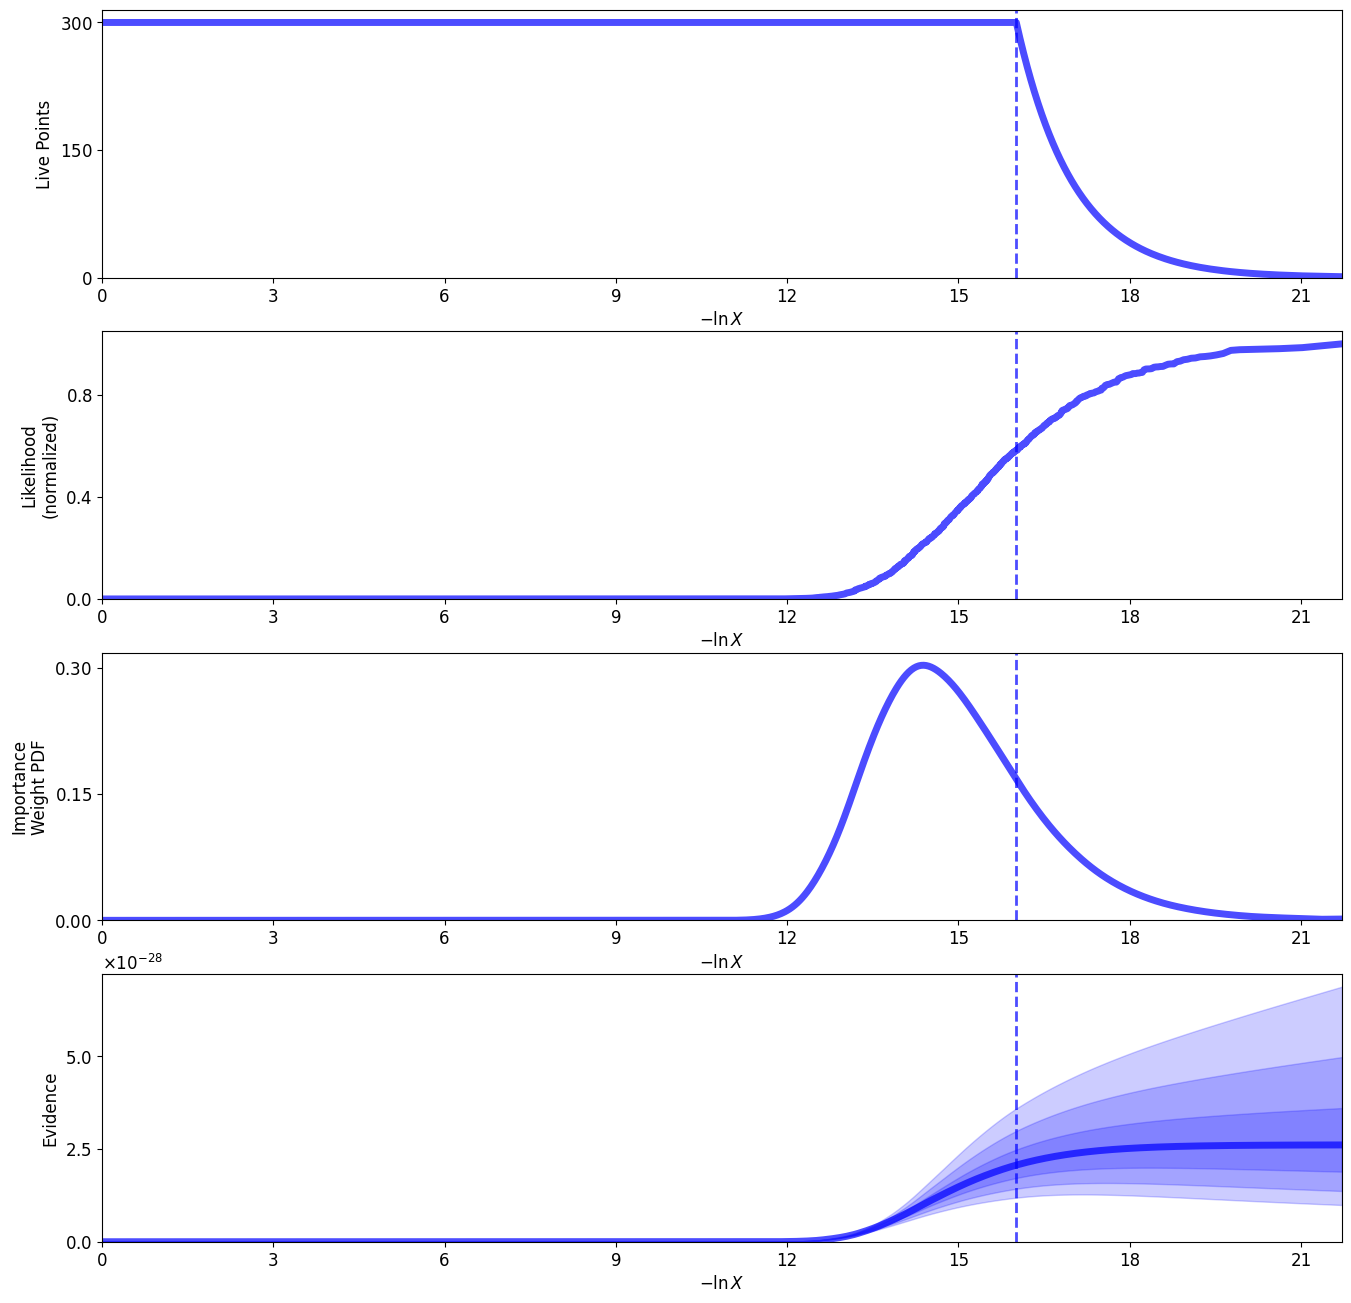

In [13]:
# Plot a summary of the run.
rfig, raxes = dyplot.runplot(sresults)

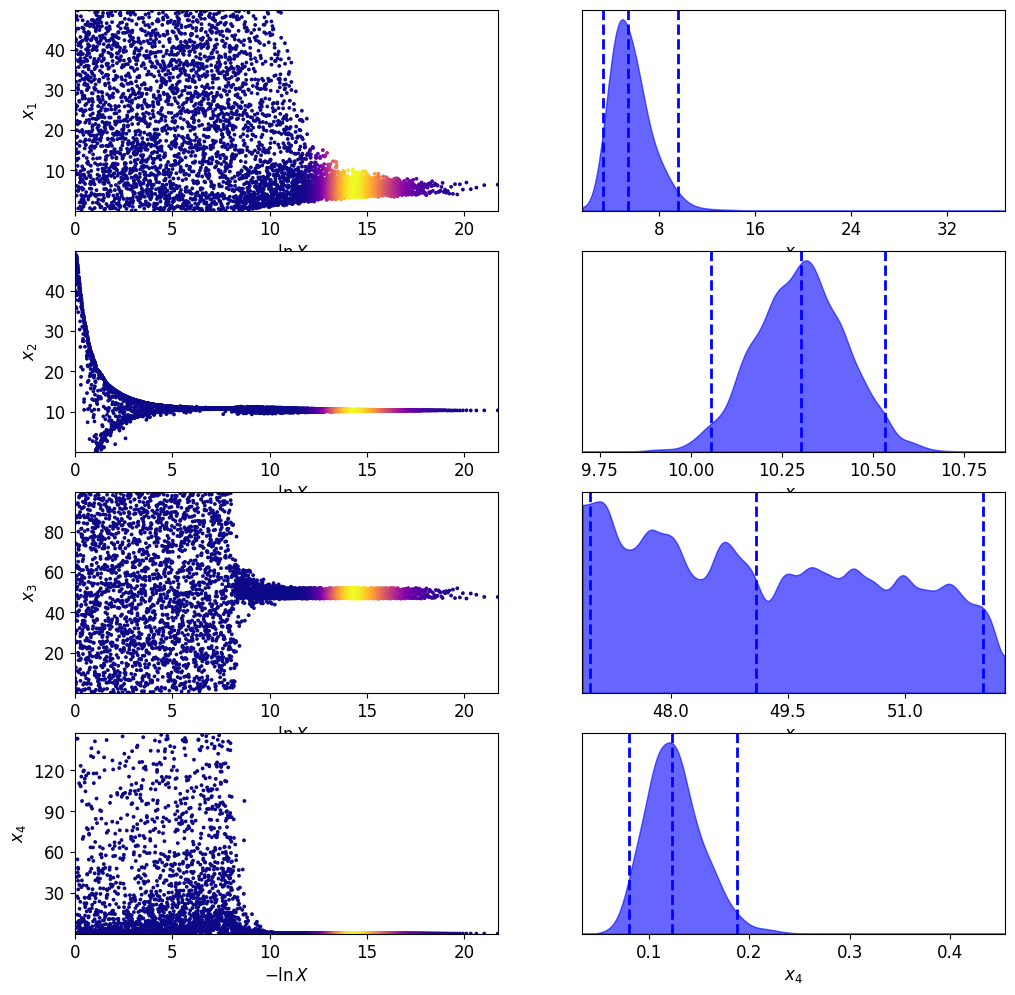

In [14]:
tfig, taxes = dyplot.traceplot(sresults)

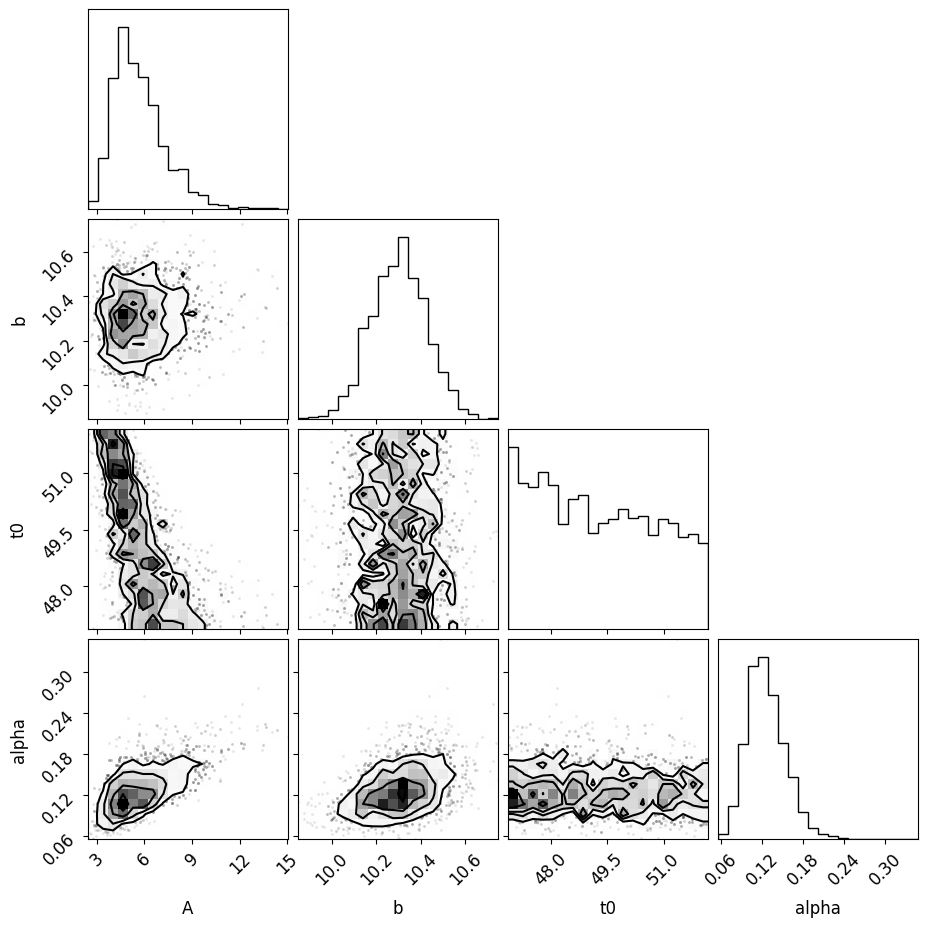

In [15]:
samples = sresults.samples  # samples
weights = np.exp(sresults.logwt - sresults.logz[-1])  # normalized weights

labels = ["A","b","t0","alpha"]

samples_equal = dyfunc.resample_equal(samples, weights)
corner.corner(samples_equal,labels=labels);

In [16]:
quantiles = [dyfunc.quantile(samps, [0.05, 0.5, 0.95], weights=weights)
             for samps in samples.T]
for q,l in zip(quantiles,labels):
    low,med,up=q
    print(l+"   "+str(med)+" +"+str(up-med)+" -"+str(med-low))



A   5.438020708051016 +3.266800445745374 -1.8407276494316114
b   10.302593064583155 +0.20350969283541964 -0.20542224380224816
t0   49.095963661852394 +2.711142323824511 -2.0478376931937987
alpha   0.12306372346156594 +0.05278013157246514 -0.03796483877329397


In [17]:
sresults.summary()

Summary
nlive: 300
niter: 4811
ncall: 106467
eff(%):  4.801
logz: -63.512 +/-  0.323


Ok now let's move on with the Gaussian profile:

In [18]:
# "Static" nested sampling.
sampler = dynesty.NestedSampler(loglike, ptform, ndim,logl_args=[data,'gprofile'],ptform_args=['gprofile'],nlive=300)
sampler.run_nested()
sresults2 = sampler.results


5038it [01:13, 68.93it/s, +300 | bound: 160 | nc: 1 | ncall: 82937 | eff(%):  6.460 | loglstar:   -inf < -52.466 <    inf | logz: -68.013 +/-  0.221 | dlogz:  0.001 >  0.309]


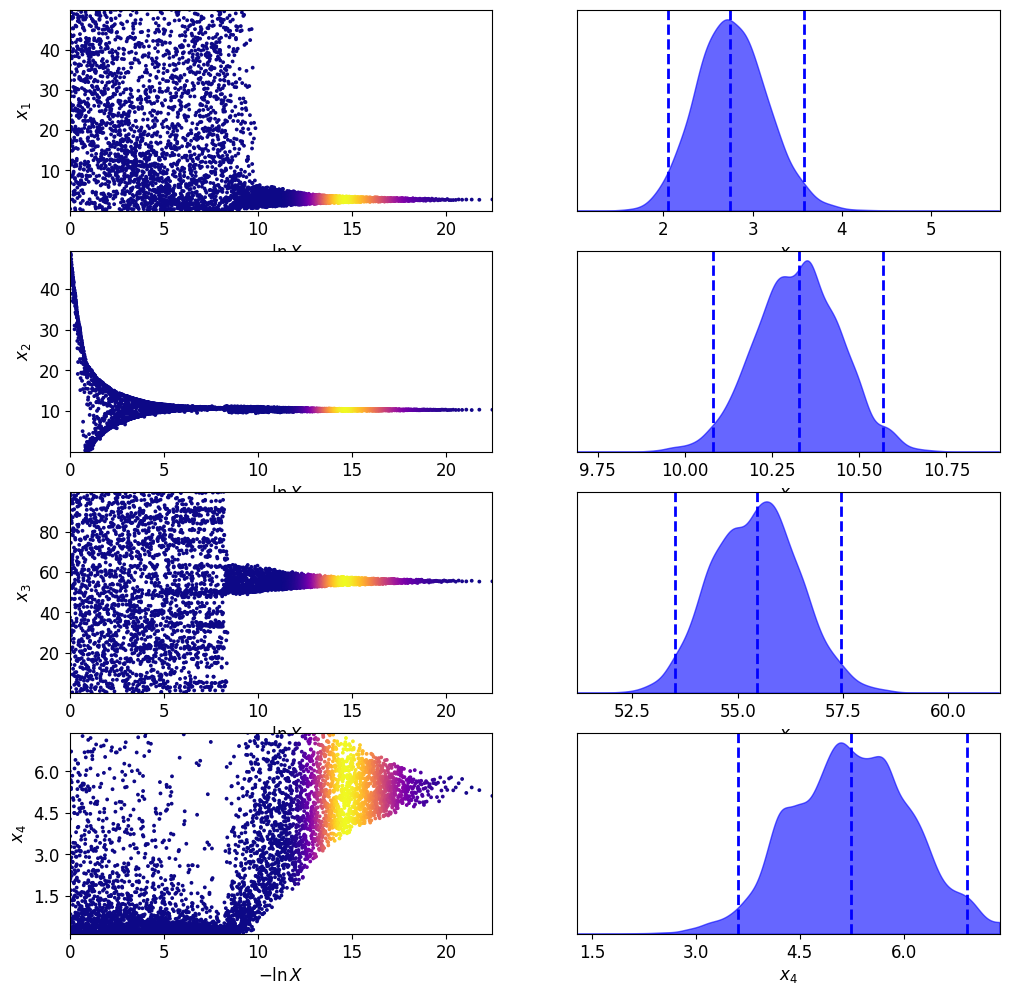

In [19]:
tfig, taxes = dyplot.traceplot(sresults2)

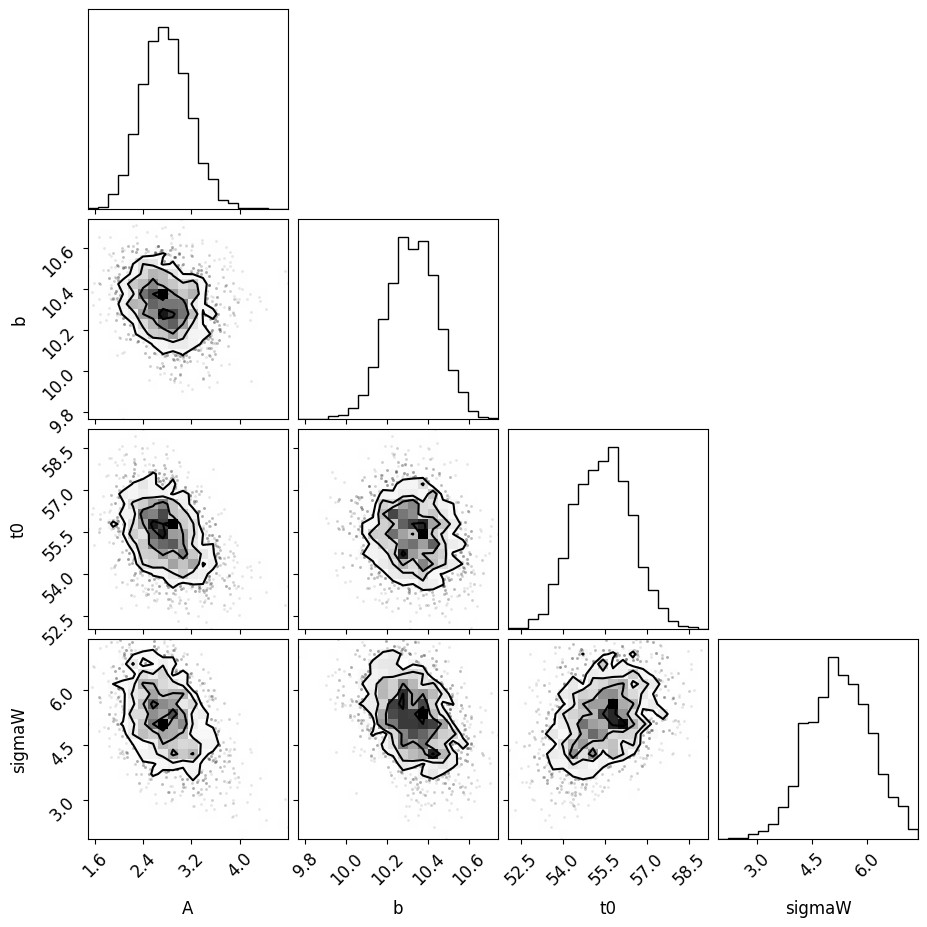

In [20]:
samples = sresults2.samples  # samples
weights = np.exp(sresults2.logwt - sresults2.logz[-1])  # normalized weights

labels = ["A","b","t0","sigmaW"]

samples_equal = dyfunc.resample_equal(samples, weights)
corner.corner(samples_equal,labels=labels);

In [21]:
sresults2.summary()

Summary
nlive: 300
niter: 5038
ncall: 82637
eff(%):  6.460
logz: -68.013 +/-  0.326


Now compute the odds ratio (assuming equal hyperpriors) between the two models:

In [22]:
np.exp(sresults.logz[-1])/np.exp(sresults2.logz[-1])

90.08618736406385

This is "very strong" evidence in favour of the burst model

Something I haven't done (but you should): 
- check if this number is robust with respect to the nested sampling hyperparameters (number of live points, dlogz threshold where the fit is terminated)
- Assign an error to this estimate of the Bayes factor.

Let's plot some models

Text(0, 0.5, 'flux')

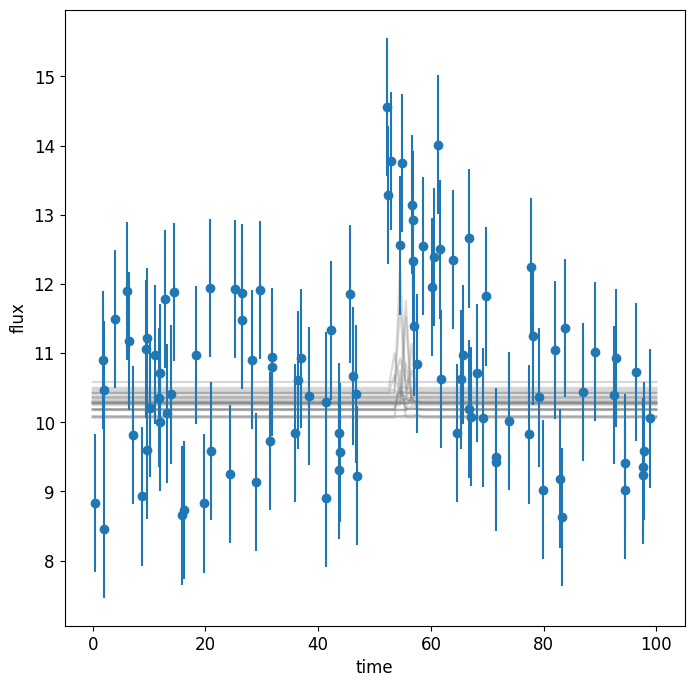

In [23]:
tgrid=np.linspace(0,100,100)

chosen_samples= samples_equal[np.random.choice(len(samples_equal),size=30)]

for chosen_theta in chosen_samples:

    ygrid =  burst(chosen_theta,tgrid)
    plt.plot(tgrid,ygrid,alpha=0.3,c='gray')
    
plt.errorbar(t,y,yerr=yerr,fmt='o')
plt.xlabel("time")
plt.ylabel("flux")

Indeed, look how badly this is describing the data... Let's try to understand why (play a bit with the fit by hand...)

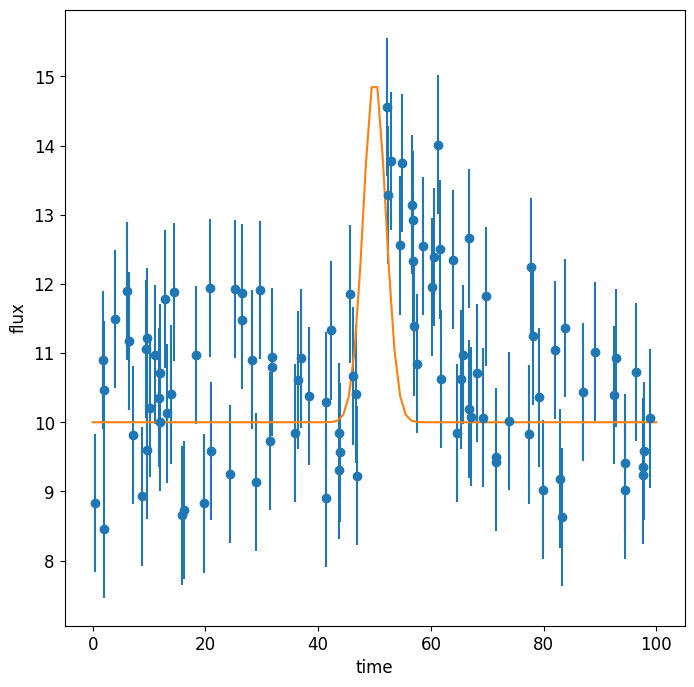

In [24]:
tgrid=np.linspace(0,100,100)
t0_quick=50
A_quick=5
b_quick=10
sigmaW_quick=2


theta_quick= np.array([A_quick,b_quick,t0_quick,sigmaW_quick])
ygrid =  gprofile(theta_quick,tgrid)

plt.errorbar(t,y,yerr=yerr,fmt='o')
plt.xlabel("time")
plt.ylabel("flux")
plt.plot(tgrid,ygrid)

Remember this does not tell you that a model is correct, only that one is better than the other.

In [ ]:
### Some tests

In [25]:
def ptform(u,model):
    """Transforms the uniform random variables `u ~ Unif[0., 1.)`
    to the parameters of interest."""

    x = np.array(u)  # copy u

    x[0] = scipy.stats.uniform(loc=Amin,scale=Amax-Amin).ppf(u[0])
    x[1] = scipy.stats.uniform(loc=bmin,scale=bmax-bmin).ppf(u[1])
    x[2] = scipy.stats.uniform(loc=t0min,scale=t0max-t0min).ppf(u[2])
   
    if model =='burst':
        x[3] = scipy.stats.loguniform.ppf(u[3],alphamin,alphamax)
    elif model =='gprofile':
        x[3] = scipy.stats.loguniform.ppf(u[3],sigmaWmin,sigmaWmax)
        #x[3] = scipy.stats.uniform(loc=sigmaWmin,scale=sigmaWmax-sigmaWmin).ppf(u[3])

    return x

In [73]:
myu= np.random.uniform(0,1,4000).reshape(4,1000)

In [74]:
myp = ptform(myu, 'burst')

(array([ 96.,  99., 102., 105., 102., 113.,  96., 117.,  86.,  84.]),
 array([-4.99226211e+00, -3.99318105e+00, -2.99409998e+00, -1.99501891e+00,
        -9.95937849e-01,  3.14321716e-03,  1.00222428e+00,  2.00130535e+00,
         3.00038641e+00,  3.99946748e+00,  4.99854855e+00]),
 <BarContainer object of 10 artists>)

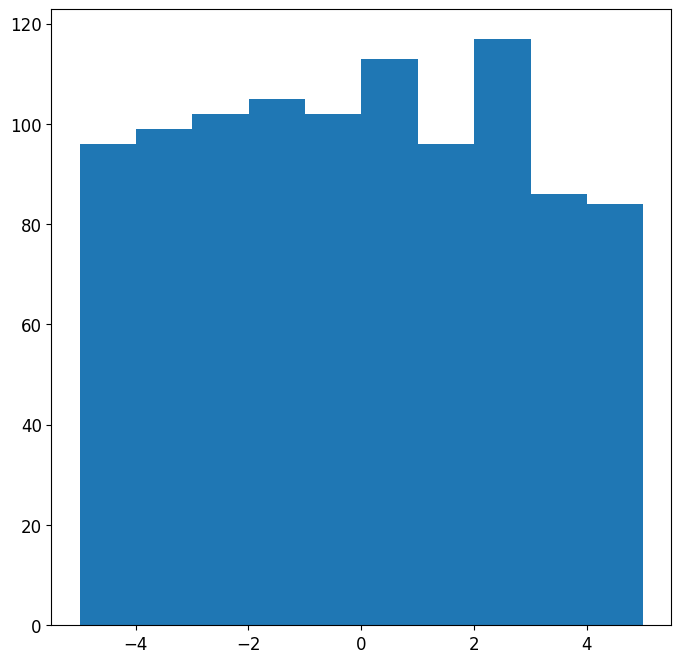

In [75]:
plt.hist(np.log(myp[3]))

In [62]:
y=scipy.stats.loguniform.ppf(np.random.uniform(0,1,1000),sigmaWmin,sigmaWmax)

(array([102.,  97., 111.,  91., 108.,  82., 110.,  94., 103., 102.]),
 array([-1.99841240e+00, -1.59865642e+00, -1.19890044e+00, -7.99144460e-01,
        -3.99388479e-01,  3.67501136e-04,  4.00123482e-01,  7.99879462e-01,
         1.19963544e+00,  1.59939142e+00,  1.99914740e+00]),
 <BarContainer object of 10 artists>)

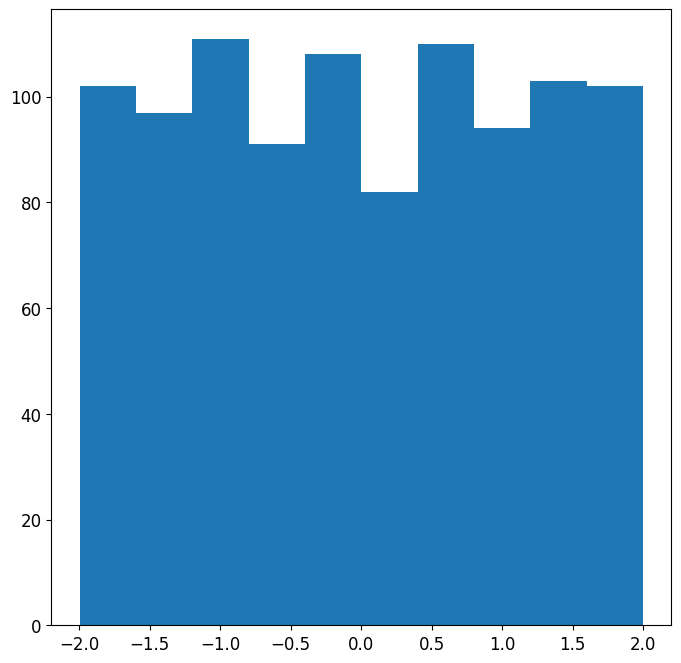

In [63]:
plt.hist(np.log(y))